In [ ]:
import csv
from google.colab import files
import math


uploaded = files.upload()
# Open the CSV file in read mode
with open('filtered_combined_eeg_df.csv', 'r') as csvfile:
  # Create a reader object
  csv_reader = csv.reader(csvfile)

  # Create a new list to store the filtered rows
  filtered_rows = []
  easy_1 =[]
  easy_2 = []
  hard = []

  # Iterate over the rows in the CSV file
  for row in csv_reader:
    # Check if the third column contains the values to remove
    if row[2] not in ['no_label', 'calibration_start', 'end_of_experiment']:
      filtered_rows.append(row)
      if row[2] == 'first_easy_calculation_block_start':
        easy_1.append(row)
      elif row[2] == 'hard_calculation_block_start':
         hard.append(row)
      elif row[2] == 'second_easy_calculation_block_start':
         easy_2.append(row)
      # If the third column does not contain the values to remove, append the row to the filtered list




# Open a new CSV file in write mode
with open('filtered_data.csv', 'w', newline='') as new_csvfile:
  # Create a writer object
  csv_writer = csv.writer(new_csvfile)
  # Write the filtered rows to the new CSV file
  csv_writer.writerows(filtered_rows)


Saving filtered_combined_eeg_df.csv to filtered_combined_eeg_df.csv


Split the data into 3 matrices, one for each exercise.

In [ ]:
import numpy as np

Fs = 250 #Sampling frequency
T = 1/Fs #Sampling interval
eeg_datapoint_time = np.arange(0, 1, T)
#Easy 1 length 42501
#Easy 2 length 50232
#Easy tot length 92733
#Hard length 33604
easy_1_array = np.delete(np.array(easy_1),2,1)
easy_2_array = np.delete(np.array(easy_2),2,1)
hard_array = np.delete(np.array(hard),2,1)
easy_1_array = np.delete(np.array(easy_1_array),0,1)
easy_2_array = np.delete(np.array(easy_2_array),0,1)
hard_array = np.delete(np.array(hard_array),0,1)

def convert_to_floats(matrix):
  new_matrix =[]
  for row in matrix:
    new_row = [float(x) for x in row]
    new_matrix.append(new_row)
  return np.array(new_matrix)


easy_1_array = convert_to_floats(easy_1_array)
easy_2_array = convert_to_floats(easy_2_array)
hard_array = convert_to_floats(hard_array)



Produce datapoints by taking 250 samples (1 second eeg recordings). We discard the last chunk which is less than 250 samples for each array.

In [ ]:
def split_into_chunks(array, chunk_size):
  num_chunks = len(array) // chunk_size
  chunks = []
  for i in range(num_chunks):
    start = i * chunk_size
    end = (i + 1) * chunk_size
    chunks.append(array[start:end])
  return chunks

easy_1_array_chunks = split_into_chunks(easy_1_array, Fs)
easy_2_array_chunks = split_into_chunks(easy_2_array, Fs)
hard_array_chunks = split_into_chunks(hard_array, Fs)

easy_1_array_chunks = np.array(easy_1_array_chunks)
easy_2_array_chunks = np.array(easy_2_array_chunks)
hard_array_chunks = np.array(hard_array_chunks)


In [ ]:
print(easy_1_array_chunks.shape)
print(easy_2_array_chunks.shape)
print(hard_array_chunks.shape)

(170, 250, 1)
(200, 250, 1)
(134, 250, 1)


Define all features functions

In [ ]:
from scipy import stats
import scipy

def mean(data):
    return np.mean(data,axis=0)

def std(data):
    return np.std(data,axis=0)

def ptp(data):
    return np.ptp(data,axis=0)

def var(data):
        return np.var(data,axis=0)

def minim(data):
      return np.min(data,axis=0)

def maxim(data):
      return np.max(data,axis=0)

def argminim(data):
      return np.argmin(data,axis=0)

def argmaxim(data):
      return np.argmax(data,axis=0)

def mean_square(data):
      return np.mean(data**2,axis=0)

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=0))

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=0)),axis=0)

def skewness(data):
    return stats.skew(data,axis=0)

def kurtosis(data):
    return stats.kurtosis(data,axis=0)

def concatenate_features(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),argminim(data),argmaxim(data),
                          mean_square(data),rms(data),abs_diffs_signal(data),
                          skewness(data),kurtosis(data)),axis=0)

Use MATLAB to compute bandpowers thanks to its easier function, and import the results

In [ ]:
!pip install scipy

from scipy.io import loadmat
from google.colab import drive
drive.mount('/content/drive')

# Replace 'path_to_your_file1.mat' with the actual path to your .mat file in Google Drive
file_path1 = '/content/drive/My Drive/powerbands/bandpowers_easy_1.mat'
mat1 = loadmat(file_path1)

file_path2 = '/content/drive/My Drive/powerbands/bandpowers_easy_2.mat'
mat2 = loadmat(file_path2)

file_path3 = '/content/drive/My Drive/powerbands/bandpowers_hard.mat'
mat3 = loadmat(file_path3)




Mounted at /content/drive


In [ ]:
# Assuming the .mat files contain a variable named 'data'
matrix1 = mat1['eeg_bandpowers_easy1']
matrix2 = mat2['eeg_bandpowers_easy2']
matrix3 = mat3['eeg_bandpowers_hard']


In [ ]:
print(np.shape(matrix1))
print(np.shape(matrix2))
print(np.shape(matrix3))

(170, 5)
(200, 5)
(134, 5)


Create feature matrices

In [ ]:
easy_1_features = np.zeros((len(easy_1_array_chunks),18))
easy_2_features = np.zeros((len(easy_2_array_chunks),18))
hard_features = np.zeros((len(hard_array_chunks),18))

for i in range(len(easy_1_array_chunks)):
  easy_1_features[i,0:13] = concatenate_features(easy_1_array_chunks[i])
  easy_1_features[i,13:18] = matrix1[i,:]
for i in range(len(easy_2_array_chunks)):
  easy_2_features[i,0:13] = concatenate_features(easy_2_array_chunks[i])
  easy_2_features[i,13:18] = matrix2[i,:]
for i in range(len(hard_array_chunks)):
  hard_features[i,0:13] = concatenate_features(hard_array_chunks[i])
  hard_features[i,13:18] = matrix3[i,:]

In [ ]:
print(np.shape(easy_1_features))
print(np.shape(easy_2_features))
print(np.shape(hard_features))


(170, 18)
(200, 18)
(134, 18)


Binary classification with random forest

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Combine easy features and create labels
X_easy = np.concatenate((easy_1_features, easy_2_features), axis=0)
y_easy = np.zeros(X_easy.shape[0])  # Label 0 for easy

# Combine with hard features and labels
X = np.concatenate((X_easy, hard_features), axis=0)
y = np.concatenate((y_easy, np.ones(hard_features.shape[0])))  # Label 1 for hard

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on test set
y_pred = clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


Accuracy: 0.9603960396039604
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98        80
         1.0       0.95      0.86      0.90        21

    accuracy                           0.96       101
   macro avg       0.96      0.92      0.94       101
weighted avg       0.96      0.96      0.96       101



Calculate losses and show confusion matrix


Training Loss: 0.0
Testing Loss: 0.03960396039603964


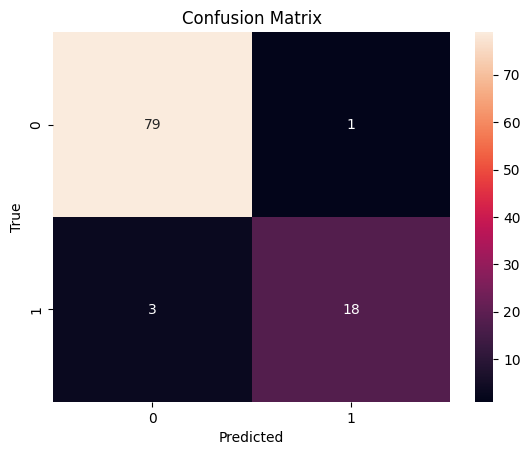

In [ ]:
# Calculate training loss
train_loss = 1 - clf.score(X_train, y_train)
print("Training Loss:", train_loss)

# Calculate testing loss
test_loss = 1 - clf.score(X_test, y_test)
print("Testing Loss:", test_loss)

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Perform classification with perceptron

Accuracy: 0.8613861386138614
              precision    recall  f1-score   support

         0.0       0.85      0.97      0.91        69
         1.0       0.91      0.62      0.74        32

    accuracy                           0.86       101
   macro avg       0.88      0.80      0.82       101
weighted avg       0.87      0.86      0.85       101

Training Loss: 0.09181141439205953
Testing Loss: 0.13861386138613863


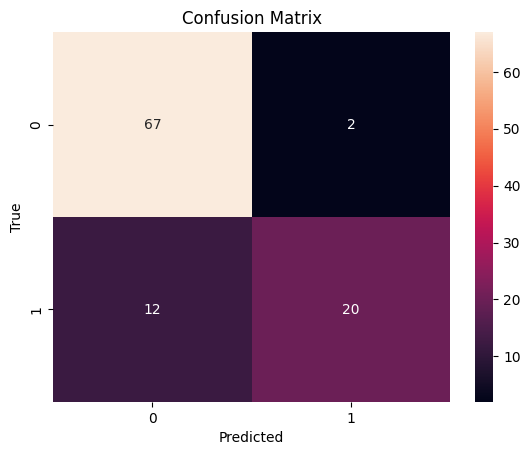

In [ ]:

from sklearn.linear_model import Perceptron

# Combine easy features and create labels
X_easy = np.concatenate((easy_1_features, easy_2_features), axis=0)
y_easy = np.zeros(X_easy.shape[0])  # Label 0 for easy

# Combine with hard features and labels
X = np.concatenate((X_easy, hard_features), axis=0)
y = np.concatenate((y_easy, np.ones(hard_features.shape[0])))  # Label 1 for hard

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Perceptron Classifier
clf = Perceptron(random_state=55)
clf.fit(X_train, y_train)

# Make predictions on test set
y_pred = clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Calculate losses
train_loss = 1 - clf.score(X_train, y_train)
print("Training Loss:", train_loss)

test_loss = 1 - clf.score(X_test, y_test)
print("Testing Loss:", test_loss)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Perform classification using a SVM

Accuracy: 0.9504950495049505
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96        69
         1.0       0.94      0.91      0.92        32

    accuracy                           0.95       101
   macro avg       0.95      0.94      0.94       101
weighted avg       0.95      0.95      0.95       101

Training Loss: 0.04466501240694787
Testing Loss: 0.04950495049504955


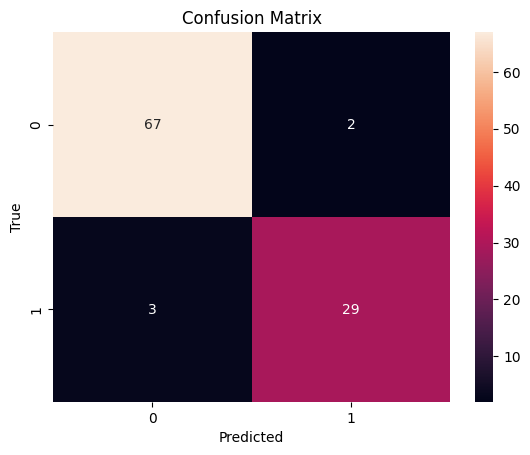

In [ ]:
from sklearn.svm import SVC

# Combine easy features and create labels
X_easy = np.concatenate((easy_1_features, easy_2_features), axis=0)
y_easy = np.zeros(X_easy.shape[0])  # Label 0 for easy

# Combine with hard features and labels
X = np.concatenate((X_easy, hard_features), axis=0)
y = np.concatenate((y_easy, np.ones(hard_features.shape[0])))  # Label 1 for hard

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Support Vector Machine Classifier
clf = SVC(kernel='linear', random_state=55)
clf.fit(X_train, y_train)

# Make predictions on test set
y_pred = clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Calculate losses
train_loss = 1 - clf.score(X_train, y_train)
print("Training Loss:", train_loss)

test_loss = 1 - clf.score(X_test, y_test)
print("Testing Loss:", test_loss)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Perform feature selection and re run the classification using SVM. The choice of SVM lays in the fact that it is better suited for binary classification and has similar loss to random forest

Let's try to only use powerbands features

In [ ]:
easy_1_features_1 = easy_1_features[:,13:18]
easy_2_features_1 = easy_2_features[:,13:18]
hard_features_1 = hard_features[:,13:18]


In [ ]:
# Combine easy features and create labels
X_easy = np.concatenate((easy_1_features_1, easy_2_features_1), axis=0)
y_easy = np.zeros(X_easy.shape[0])  # Label 0 for easy

# Combine with hard features and labels
X = np.concatenate((X_easy, hard_features_1), axis=0)
y = np.concatenate((y_easy, np.ones(hard_features_1.shape[0])))  # Label 1 for hard

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest Classifier
clf = SVC(kernel='linear', random_state=10)
clf.fit(X_train, y_train)

# Make predictions on test set
y_pred = clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.8613861386138614
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90        69
         1.0       0.76      0.81      0.79        32

    accuracy                           0.86       101
   macro avg       0.84      0.85      0.84       101
weighted avg       0.86      0.86      0.86       101



Training Loss: 0.11910669975186106
Testing Loss: 0.13861386138613863


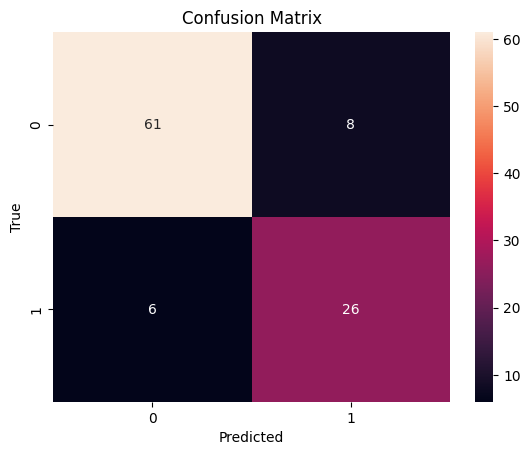

In [ ]:
# Calculate training loss
train_loss = 1 - clf.score(X_train, y_train)
print("Training Loss:", train_loss)

# Calculate testing loss
test_loss = 1 - clf.score(X_test, y_test)
print("Testing Loss:", test_loss)

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Via SelectKBest we try to automatically select the 5 best features without handpicking them

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif

# Combine easy features and create labels
X_easy = np.concatenate((easy_1_features, easy_2_features), axis=0)
y_easy = np.zeros(X_easy.shape[0])  # Label 0 for easy

# Combine with hard features and labels
X = np.concatenate((X_easy, hard_features), axis=0)
y = np.concatenate((y_easy, np.ones(hard_features.shape[0])))  # Label 1 for hard

# Apply SelectKBest with mutual_info_classif scoring function
selector = SelectKBest(mutual_info_classif, k=5)  # Select top 5 features
X_new = selector.fit_transform(X, y)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)
print("Selected Feature Indices:", selected_feature_indices)


Selected Feature Indices: [ 1  8  9 10 17]


Perform classification with the 5 best automatically selected features (we half the original number to see if there is some sort of improvement)

In [ ]:
easy_1_features_2 = easy_1_features[:,selected_feature_indices]
easy_2_features_2 = easy_2_features[:,selected_feature_indices]
hard_features_2 = hard_features[:,selected_feature_indices]


In [ ]:
# Combine easy features and create labels
X_easy = np.concatenate((easy_1_features_2, easy_2_features_2), axis=0)
y_easy = np.zeros(X_easy.shape[0])  # Label 0 for easy

# Combine with hard features and labels
X = np.concatenate((X_easy, hard_features_2), axis=0)
y = np.concatenate((y_easy, np.ones(hard_features_2.shape[0])))  # Label 1 for hard

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest Classifier
clf = SVC(kernel='linear', random_state=55)
clf.fit(X_train, y_train)

# Make predictions on test set
y_pred = clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


Accuracy: 0.9207920792079208
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.94        69
         1.0       0.96      0.78      0.86        32

    accuracy                           0.92       101
   macro avg       0.93      0.88      0.90       101
weighted avg       0.92      0.92      0.92       101



Training Loss: 0.052109181141439254
Testing Loss: 0.07920792079207917


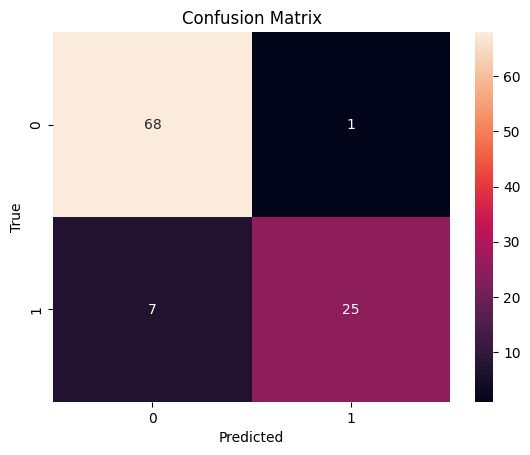

In [ ]:
# Calculate training loss
train_loss = 1 - clf.score(X_train, y_train)
print("Training Loss:", train_loss)

# Calculate testing loss
test_loss = 1 - clf.score(X_test, y_test)
print("Testing Loss:", test_loss)

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Augment features with alpha and beta powerbands

In [ ]:
easy_1_features_3 = np.concatenate((easy_1_features_2[:,:],easy_1_features[:,15:17]),axis=1)
easy_2_features_3 = np.concatenate((easy_2_features_2,easy_2_features[:,15:17]),axis=1)
hard_features_3 = np.concatenate((hard_features_2,hard_features[:,15:17]),axis=1)

In [ ]:
# Combine easy features and create labels
X_easy = np.concatenate((easy_1_features_3, easy_2_features_3), axis=0)
y_easy = np.zeros(X_easy.shape[0])  # Label 0 for easy

# Combine with hard features and labels
X = np.concatenate((X_easy, hard_features_3), axis=0)
y = np.concatenate((y_easy, np.ones(hard_features_3.shape[0])))  # Label 1 for hard

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest Classifier
clf = SVC(kernel='linear', random_state=55)
clf.fit(X_train, y_train)

# Make predictions on test set
y_pred = clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))


Accuracy: 0.9603960396039604
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97        69
         1.0       0.97      0.91      0.94        32

    accuracy                           0.96       101
   macro avg       0.96      0.95      0.95       101
weighted avg       0.96      0.96      0.96       101



Training Loss: 0.05707196029776673
Testing Loss: 0.03960396039603964


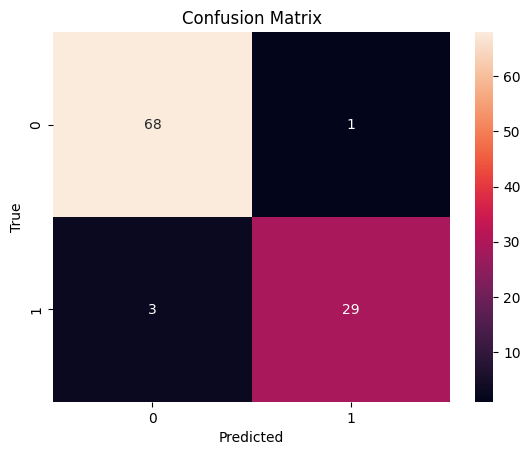

In [ ]:
# Calculate training loss
train_loss = 1 - clf.score(X_train, y_train)
print("Training Loss:", train_loss)

# Calculate testing loss
test_loss = 1 - clf.score(X_test, y_test)
print("Testing Loss:", test_loss)

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Now we try to perform multiclass classification to see if we are able to discriminate between the 2 easy tasks. We will use the random forest algorithm.

Accuracy: 0.6831683168316832
              precision    recall  f1-score   support

         0.0       0.55      0.53      0.54        34
         1.0       0.58      0.63      0.60        35
         2.0       0.97      0.91      0.94        32

    accuracy                           0.68       101
   macro avg       0.70      0.69      0.69       101
weighted avg       0.69      0.68      0.69       101

Training Loss: 0.0
Testing Loss: 0.3168316831683168


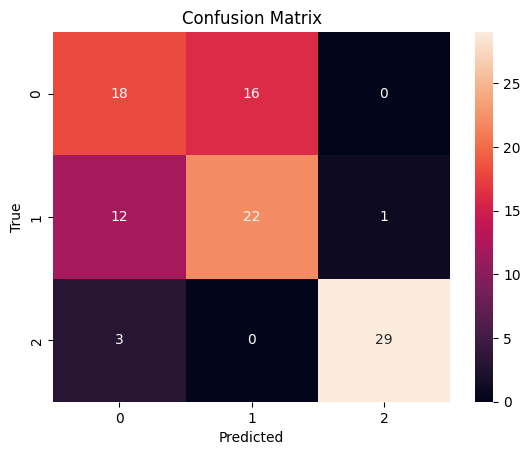

In [ ]:
# Combine all feature matrices and create corresponding labels
X = np.concatenate((easy_1_features, easy_2_features, hard_features), axis=0)
y = np.concatenate((np.zeros(easy_1_features.shape[0]),  # Label 0 for easy_1
                    np.ones(easy_2_features.shape[0]),   # Label 1 for easy_2
                    np.ones(hard_features.shape[0]) * 2)) # Label 2 for hard

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest Classifier (or any other multiclass classifier)
clf = RandomForestClassifier(random_state=55)
clf.fit(X_train, y_train)

# Make predictions on test set
y_pred = clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Calculate training loss
train_loss = 1 - clf.score(X_train, y_train)
print("Training Loss:", train_loss)

# Calculate testing loss
test_loss = 1 - clf.score(X_test, y_test)
print("Testing Loss:", test_loss)

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Let's retry with the automatically selected features

Accuracy: 0.693069306930693
              precision    recall  f1-score   support

         0.0       0.58      0.56      0.57        34
         1.0       0.59      0.66      0.62        35
         2.0       0.97      0.88      0.92        32

    accuracy                           0.69       101
   macro avg       0.71      0.70      0.70       101
weighted avg       0.70      0.69      0.70       101

Training Loss: 0.0
Testing Loss: 0.306930693069307


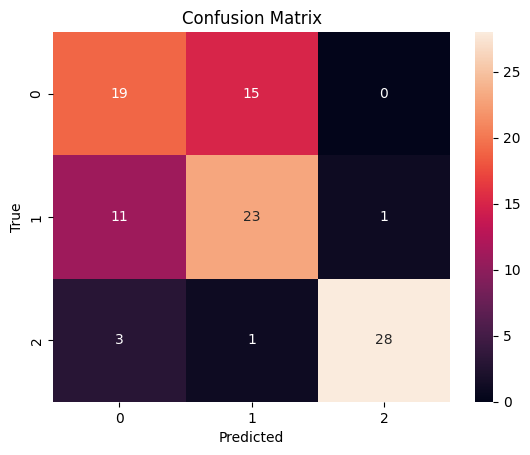

In [ ]:
# Combine all feature matrices and create corresponding labels
X = np.concatenate((easy_1_features_3, easy_2_features_3, hard_features_3), axis=0)
y = np.concatenate((np.zeros(easy_1_features_3.shape[0]),  # Label 0 for easy_1
                    np.ones(easy_2_features_3.shape[0]),   # Label 1 for easy_2
                    np.ones(hard_features_3.shape[0]) * 2)) # Label 2 for hard

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest Classifier (or any other multiclass classifier)
clf = RandomForestClassifier(random_state=55)
clf.fit(X_train, y_train)

# Make predictions on test set
y_pred = clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

# Calculate training loss
train_loss = 1 - clf.score(X_train, y_train)
print("Training Loss:", train_loss)

# Calculate testing loss
test_loss = 1 - clf.score(X_test, y_test)
print("Testing Loss:", test_loss)

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
